# examples for `hostess.aws.s3`

## introduction

`hostess.aws.s3` is a collection of utilities for working with S3 
objects. Its centerpiece is a class called `Bucket`, which offers
a straightforward interface to a single S3 bucket.

### capabilities

`hostess.aws.s3` is designed as a streamlined alternative to `boto3`'s
high-level S3 API. It is intended to make it easy to integrate S3 
objects into Python workflows without writing a lot of boilerplate. 
It makes read/write operations extremely simple, including reads and 
writes from and to in-memory Python objects.

In addition to simple I/O operations, it offers special functionality 
for several types of tasks that are frequently encountered when working 
with "big data" on S3, but are not straightforward to execute with 
existing tools, specifically:

* building searchable indices of buckets containing many objects
* modifying object storage classes
* writing larger-than-memory or intermittently-streamed data
  to S3 objects

### limitations

`hostess.aws.s3` does not provide interfaces for S3 administrative 
operations, including creating and deleting buckets or managing
object and bucket permissions. If you need to perform automated S3 
admin tasks of this type, you will need to supplement `hostess` with 
something such as `boto3`, `awscli`, the AWS Web Console. (`hostess.aws` 
does offer some generic utilities to make using `boto3` easier.) `hostess` 
may expand its S3 administrative capabilities in the future.

### requirements

1. If you have no valid AWS credentials, `hostess.aws` (like any other AWS 
interface) will not function. By default, `hostess` uses the 'default' 
profile from ~/.aws/credentials. This can be modified in 
`hostess.config.user_config` or by manually constructing a `boto3` session 
or client with `init_session` or `init_client` from `hostess.aws.utilities`.

2. You need appropriate AWS permissions, both for the specific API call you're
making and the specific S3 resources you wish to access. You cannot,
for instance, use `Bucket.ls()` without the ListObjectsV2 permission, or
`Bucket.put()` without the PutObject permission. 

A complete discussion of AWS credential and permissions management is beyond 
the scope of this document. For overviews, please refer to AWS documentation on 
[account creation](https://docs.aws.amazon.com/accounts/latest/reference/manage-acct-creating.html),
[credentials](https://docs.aws.amazon.com/IAM/latest/UserGuide/security-creds.html),
and [S3 permissions](https://docs.aws.amazon.com/AmazonS3/latest/userguide/access-policy-language-overview.html).

### note and caveat
This tutorial will walk you through the creation of an s3 bucket using your 
available AWS credentials and then put data into that bucket. This will start to
incur costs attached to your AWS credentials. If this tutorial is run
without modification, then the total costs should be approximately one fifth of 
a cent -- less than the electricity you are using to run your computer. However,
if this is unacceptable to you or makes you uncomfortable,
you should proceed with caution or not at all. We (the authors of `hostess`)
disclaim responsibility. (See the appendix for a breakdown of estimated costs.)

----

## make an S3 bucket

This isn't a showcase of `hostess`'s capabilities -- it just uses `boto3`
and the Python Standard Library -- but it's a necessary 
precursor to the subsequent examples. If you have an existing empty bucket 
you'd like to use, you can skip this section, and if you've already run 
through this section before, you can reuse the bucket you made.

AWS bucket names have to be unique within an AWS Partition (grouping of
Regions), so we'll make a bucket with a random name. If you'd like to
reuse this bucket later, make sure you note down or can easily look up 
the name (like in the AWS Web Console).

In [1]:
from random import randint
from hostess.aws.utilities import init_client

bucket_name = f"hostess-cats-{''.join(str(randint(0, 9)) for _ in range(9))}"
response = init_client('s3').create_bucket(Bucket=bucket_name)
if response['ResponseMetadata']['HTTPStatusCode'] == 200:
    print("We're ready to continue.")
    print(f"The bucket name is {bucket_name}.")
else:
    print("Something went wrong. Take a look at the response.")

We're ready to continue.
The bucket name is hostess-cats-793295202.


## initialize a `Bucket`

Unless you require special configuration, it's extremely straightforward
to initialize a `hostess` `Bucket`: just pass the name of the bucket.

In [2]:
# initialize a Bucket object associated with our shiny new S3 bucket
from hostess.aws.s3 import Bucket

bucket = Bucket(bucket_name)

# Verify that it's empty. We'll discuss `Bucket.ls()` more later.
len(bucket.ls())==0

True

## read/write operations on buckets

There's not a lot you can do with an empty bucket, so let's take the 
only sensible step and turn our bucket into a repository of cat pictures.

First, let's add a quick README file to the bucket to clarify our intent 
and demonstrate `Bucket`'s basic I/O capabilities.

In [3]:
# compose helpful documentation and write it to a local file

readme = """# cat picture repository
This bucket contains pictures of cats. Cats are
small predatory mammals often kept as pets. Users who are unfamiliar
with cats may wish to consult some 
[basic reference material](https://en.wikipedia.org/wiki/Cat) before
browsing the bucket in order to avoid confusion.
"""

with open("DRAFT_README.md", "w") as stream:
    stream.write(readme)

In [4]:
# write the README to the bucket. The first two arguments of 
# `Bucket.put()` are a source and a destination. Here, we're using
# a path to a local file (the file we just wrote) as the source.
# The second argument is the object key you'd like to write your
# data to. "README.md" seems fine in this case.
bucket.put("DRAFT_README.md", "README.md")

# Now, load the README into memory and render it to make sure
# our documentation made it to the bucket safely.
from IPython.display import Markdown

# Bucket.read() reads an S3 object directly into a Python object,
# by default a string. pass mode="rb" to read it as bytes instead.
# If this command prints the text of our README as Markdown, then
# the file has been successfully written to and read from the s3
# bucket.
Markdown(bucket.read("README.md"))

# cat picture repository
This bucket contains pictures of cats. Cats are
small predatory mammals often kept as pets. Users who are unfamiliar
with cats may wish to consult some 
[basic reference material](https://en.wikipedia.org/wiki/Cat) before
browsing the bucket in order to avoid confusion.


----

## download cat pictures

This isn't a special `hostess` feature, either, but we *do* need real content 
to put in our bucket, so let's grab some cat pictures from the Cat as 
a Service API. This should take about 20 seconds, depending
on internet weather.

This will write the cat pictures to an in-memory array object
`catbytes`, not to your local filesystem.

*Note: We don't recommend displaying the `catbytes`
object in Jupyter; it'll be a **lot** of binary gibberish.*

In [5]:
from collections import defaultdict
from io import BytesIO
import requests
from hostess.utilities import mb

# feline binary array
catbytes = []
# number of cats per tag
cats_per_tag = 3
for adj in ("cute", "angry", "white", "black", "tabby"):
    print(f"fetching pictures of {adj} cats...")
    for i in range(cats_per_tag):
        # get data for a cat picture
        resp = requests.get(f"https://cataas.com/cat/{adj}")
        # parse mimetype so we know the image format (jpeg, gif, &c)
        ftype = resp.headers['Content-Type'].replace('image/', '')
        # save data & metadata in our list
        catbytes.append(
            {'data': resp.content, "prefix": adj, 'fn': f"cat_{i}.{ftype}"}
        )
        print(f"{i + 1}/{cats_per_tag}...", end="")
    print("")
print("... done.")
# integrity check
assert all(isinstance(c['data'], bytes) for c in catbytes)
print("All cat pictures are Python bytes objects,", end=" ")
# summary info
print(
    f"{mb(sum(len(c['data']) for c in catbytes))} MB total volume."
)

fetching pictures of cute cats...
1/3...2/3...3/3...
fetching pictures of angry cats...
1/3...2/3...3/3...
fetching pictures of white cats...
1/3...2/3...3/3...
fetching pictures of black cats...
1/3...2/3...3/3...
fetching pictures of tabby cats...
1/3...2/3...3/3...
... done.
All cat pictures are Python bytes objects, 0.73 MB total volume.


## write cat pictures to the bucket

You saw a moment ago that `hostess.aws.s3.Bucket` can write local files to
S3 objects. It can do the same with in-memory objects.

### serial uploads

`Bucket` supports both **serial** and **parallel** forms of most basic I/O
operations, including `put()`. Passing a single source and destination, as
follows, makes `Bucket` operate in serial mode:

In [6]:
%%time
# put the cat pictures in the bucket one by one
for c in catbytes:
    bucket.put(c['data'], f"{c['prefix']}/{c['fn']}")

CPU times: user 82.2 ms, sys: 19 ms, total: 101 ms
Wall time: 3.38 s


### parallel uploads

Passing sequences of sources and destinations makes `Bucket` operate
in parallel mode. It performs the API calls in multiple threads and
returns all the results in a `list` (even if those results are `None`,
like for `put()`). AWS encourages the use of this type of 
['horizontal scaling'](https://docs.aws.amazon.com/whitepapers/latest/s3-optimizing-performance-best-practices/horizontal-scaling-and-request-parallelization-for-high-throughput.html),
so it's typically a good option if you know everything you need to
upload/download/etc. from the outset. This should be about twice as
fast as the serial operation in the previous cell:

In [7]:
%%time
# 'flattened' version of the for loop from the earlier cell
cat_data = [c['data'] for c in catbytes]
cat_keys = [f"{c['prefix']}/{c['fn']}" for c in catbytes]
results = bucket.put(cat_data, cat_keys)

CPU times: user 153 ms, sys: 24.3 ms, total: 178 ms
Wall time: 1.73 s


#### a note on supported types

`Bucket.put()` supports `bytes`, `str`, `StringIO`, and
`BytesIO`. If you want to write a `str`, pass `literal_str=True` so that 
`Bucket` doesn't interpret it as the path to a local file. All our cat
pictures were already `bytes`, so we didn't need to do any preprocessing.

#### a note on thread count

By default, `Bucket` uses 4 threads for auto-threaded operations.
You can change this by passing the `n_threads` 
argument to `Bucket`, or setting `Bucket.n_threads` after initialization.
Setting `n_threads` to `None` turns off auto-threading.
A different number may be better depending on network speed, latency,
object size, etc. 

### indexing our cat pictures

Now that we've populated our bucket, we can build an index for it
to ensure our uploads worked as we expected and help users find the
specific cat pics they need.

`Bucket` offers a wealth of options for exploring buckets, and one
of its most powerful features is its `df()` method.
If you access it before populating a `Bucket`'s contents, it 
immediately indexes the entirety of the bucket's contents, cache the
results in `Bucket.index`, and then returns them as a pandas DataFrame.
Subsequent calls to `df()` will use these cached contents rather
than performing the full indexing process again. (If you _need_ to
re-index, call `Bucket.update_contents()` first.)

*CAUTION: don't call this casually on really, really, big buckets
(containing e.g. millions of objects or more),
especially if you don't care about their entire contents -- it will 
take a long time to run, and in the worst cases, can even create a 
larger-than-memory index. See below for how to index buckets
in a more controlled way.*

In [8]:
# look at that wealth of content...
index = bucket.df()
index

,Key,LastModified,ETag,Size,StorageClass
0,README.md,2023-12-08 07:01:48+00:00,"""6ff2921d45d358de4d71d8910d14e5b5""",296,STANDARD
1,angry/cat_0.jpeg,2023-12-08 07:03:27+00:00,"""42a2e642c3954ec71d7795f8c6c58f58""",45522,STANDARD
2,angry/cat_1.jpeg,2023-12-08 07:03:27+00:00,"""42a2e642c3954ec71d7795f8c6c58f58""",45522,STANDARD
3,angry/cat_2.jpeg,2023-12-08 07:03:27+00:00,"""cf6aceb0c63a4a50f9a34f7590e17a46""",39226,STANDARD
4,black/cat_0.jpeg,2023-12-08 07:03:27+00:00,"""dff6e6acd6560fbc6611fb3736840da8""",51679,STANDARD
5,black/cat_1.jpeg,2023-12-08 07:03:28+00:00,"""cb3b352574e8b010efa14eb520aa44ab""",33392,STANDARD
6,black/cat_2.jpeg,2023-12-08 07:03:28+00:00,"""3adca9d744610ca1314c55be595ab4cd""",125037,STANDARD
7,cute/cat_0.jpeg,2023-12-08 07:03:27+00:00,"""a42a11e4d637b54abdde096c1b534660""",83521,STANDARD
8,cute/cat_1.jpeg,2023-12-08 07:03:27+00:00,"""ace93ebc2cf98a2161d1369766ccb8d1""",25275,STANDARD
9,cute/cat_2.jpeg,2023-12-08 07:03:27+00:00,"""1471fe0cfacf434de18c362e35dc1b26""",32142,STANDARD


In [9]:
# for larger buckets, having immediate access to all of pandas's affordances
# can be a lifesaver. say you wanted to know the total size of all the JPEGs
# in the bucket:
jpeg_mb = mb(index.loc[index['Key'].str.endswith('jpeg'), 'Size'].sum())
print(f"There are {jpeg_mb} MB of cat JPEGs.")

There are 0.73 MB of cat JPEGs.


## reading cat pictures from the bucket

Now that we've got an index of cat pictures, we can easily download them
in parallel, either into memory or to disk. Let's try it both ways, 
first into memory.

#### a note on `Bucket.get()`'s signature

By default, `Bucket.get()` reads S3 objects into memory as 
Python BytesIO objects. If you want that behavior, which we
do here, you don't have to explicitly pass a list as the 
second argument of `get()` to use it in parallel.

We uploaded 15 files and got 15 objects back.


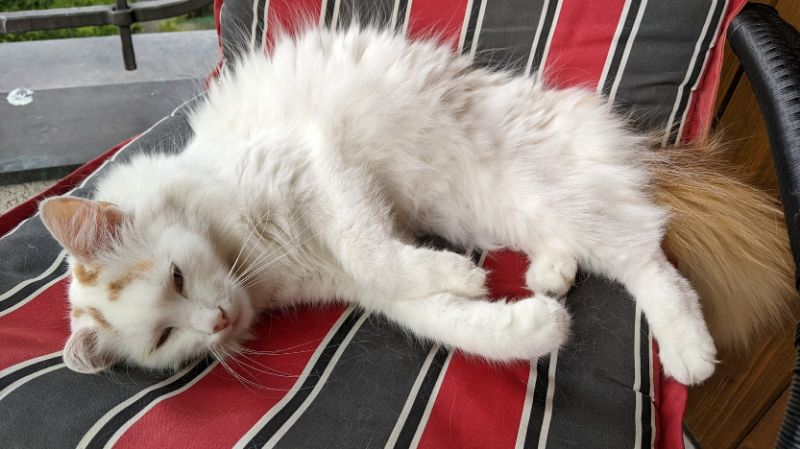

In [10]:
# read to in-memory objects
from random import choice
from PIL import Image

# just grab the cat pictures, not the README
pic_keys = index.loc[index['Key'].str.contains('cat'), 'Key']
catbuffers = bucket.get(pic_keys)
# the moment of truth for our round-trip operation...
print(f"We uploaded {len(catbytes)} files and got {len(catbuffers)} objects back.")
Image.open(choice(catbuffers))

In [11]:
%%time

# write the cat pics into a subfolder of your working directory 
# named 's3_cat_mirror.' `Bucket.get()` will automatically 
# create the necessary directory structure to mirror the 
# organization of the s3 bucket, treating object prefixes like
# the names of directories. (See notes on terminology in the appendix.)
# In this case, there will
# end up being directories for each adjectival category of cat.
results = bucket.get(pic_keys, "cat_s3_mirror/" + pic_keys)

CPU times: user 188 ms, sys: 32.6 ms, total: 221 ms
Wall time: 883 ms


In [12]:
# let's do a completeness check to make sure that we
# actually got all of the cat pictures
from pathlib import Path
import pandas as pd
from hostess.directory import index_breadth_first, make_treeframe

# we should have the same total set of pictures. let's compare names
# and sizes.
local_index = pd.DataFrame(index_breadth_first("cat_s3_mirror"))
# strip the local subdirectory name:
local_index['path'] = local_index['path'].str.replace('cat_s3_mirror/', '')
for _, local in local_index.iterrows():
    # don't care about directories
    if local['directory'] is True:
        continue
    remote = index.loc[index['Key'].str.endswith(local['path'])]
    assert len(remote) == 1, "missing? duplicates? not great."
    remote = remote.iloc[0]
    assert mb(remote['Size'], 3) == local['size']
print("everything matches!")

everything matches!


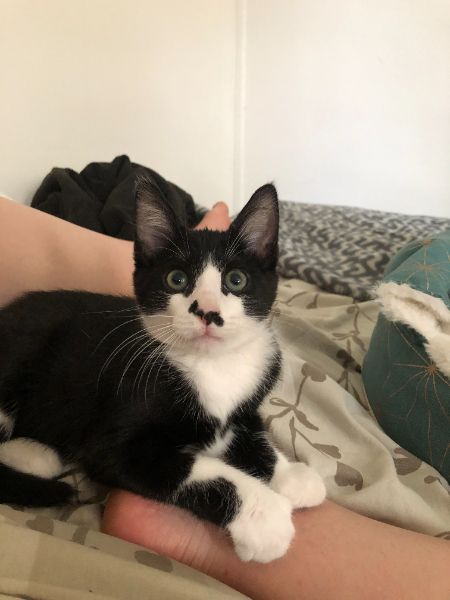

In [13]:
# and we can do a direct visual comparison to make sure. this cell
# and the next cell should display the same picture when you run them,
# because they are attempting to open and display the same file
# from your local file system and the remote s3 bucket.
Image.open(f"cat_s3_mirror/{local['path']}")

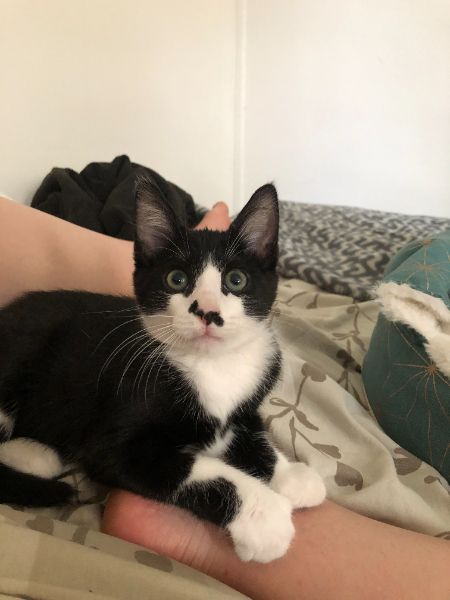

In [14]:
Image.open(bucket.get(local['path']))

## cleanup

Now that we're done, let's go ahead and delete all the objects in 
the bucket, and the bucket itself (you can't delete a bucket with 
anything in it).

In [15]:
# delete all objects
_ = bucket.rm(bucket.df()['Key'])

# is it empty?
bucket.update_contents()
assert len(bucket.df()) == 0

In [16]:
# delete the bucket
response = init_client('s3').delete_bucket(Bucket=bucket_name)
if response['ResponseMetadata']['HTTPStatusCode'] == 204:
    print("Cleanup complete. Bucket deleted.")
else:
    print("Something went wrong. Take a look at the response.")

Cleanup complete.


---
## appendix

### general s3 notes and vocab

As one more preliminary, we'd like to make a few quick notes about S3. These 
notes aren't specific to `hostess`. They're statements about S3 in general.

S3 objects are designed to look a lot like files, S3 buckets
are designed to look a lot like filesystems, and in many cases, they 
can be used like files and filesystems. They aren't, though,
and we prefer to use precise vocabulary to emphasize the differences.

The full name of an S3 object is called its **_object key name_** or just **_key_**. 
This includes its full 'path' in addition to its 'file name'. The components of the
'path' prior to the 'file name' are called **_prefixes_**. Prefixes are loosely
analogous to directories in a filesystem, and interfaces often
display them as if they were. However, prefixes are not actually directories,
and a key is not actually a path. Directories are a type of file, but 
prefixes are just 
["a string of characters at the beginning of the object key name"](https://docs.aws.amazon.com/AmazonS3/latest/userguide/using-prefixes.html) that can be used to help organize objects and permissions. 
They cannot be renamed/moved, given AWS resource tags, or otherwise directly manipulated.

Similarly, unlike files, S3 objects also cannot be renamed / moved. "Moving" an
S3 object always means making a complete copy of it with a different key
and subsequently deleting the original, even if the new copy is in the 
same "filesystem" (bucket). It is no slower to copy an object
from one bucket to another than to copy an object within the same
bucket (unless the buckets are in different AWS Regions).

Finally, unlike files, S3 objects are immutable. Although it is possible to read
just a portion of an S3 object, it is not possible to perform incremental
writes to an S3 object. Anything that looks like a tail-write to an S3
object actually overwrites the whole object with a slightly modified
copy of itself. This tends to be horribly inefficient. Multipart uploads
provide the closest approximation to 'real' tail-writes, and they don't
actually create accessible objects until they're completed.

### a diagnostic tip

If you are having trouble accessing an S3 resource via `hostess`, you can
quickly rule out some basic possibilities by calling `hostess.aws.utilities.whoami()`. 
This function performs an API call that is *always* available to any AWS account, 
even if an administrator specifically tries to deny it 
([STS GetCallerIdentity](https://docs.aws.amazon.com/STS/latest/APIReference/API_GetCallerIdentity.html)).
If it fails, either there is something wrong with your account credentials, or some network 
issue is preventing you from accessing an AWS API endpoint. If it doesn't, the problem
is with access to the resource or API action. Permissions might be wrong, the
resource might not exist, it might be in a different region than expected, or your
network is specifically blocking access to that resource.

### `hostess.aws.s3`'s relationship to `boto3` (advanced topic)

`hostess.aws.s3` works primarily as a high-level interface to `boto3`'s low-level S3 API. Due to philosophical differences, it makes almost no use of the `boto3` high-level `Bucket` object, and should be considered a reimagining of that object rather than a wrapper for it. `hostess` `Buckets` do not automatically instantiate or grant access to `boto3` `Buckets`. However, they *do* wrap `boto3` client, resource, and session objects. If users require access to portions of the S3 API not included in `hostess`, they may reference these attributes of a `hostess` `Bucket` in order to perform API calls using the same session/client/resource that underlies the methods of their `hostess` `Bucket`. They may even use them to instantiate a similarly-configured `boto3` `Bucket`, if they would like things to get confusing.

### `Bucket.df()` column specification

* Key: object key (`object`)
* LastModified: last modified time (`datetime64[ns, tzutc()]`)
* ETag: S3-generated object tag. Usually the md5 hash, but this is not guaranteed. (`object`)
* Size: object size in bytes (`int64`)
* StorageClass: [storage class, e.g. DEEP_ARCHIVE or STANDARD](https://aws.amazon.com/s3/storage-classes/)
    (`object`)


### breakdown of estimated costs for this Notebook 

Running this Notebook as-is should incur approximately
a fifth of a cent in AWS costs.

* This estimate assumes that you take an extended break in the middle
  of running this Notebook and retain the cat pictures in S3 for 4 hours.
* This Notebook also makes DELETE requests, but DELETEs are free. The same is true of data transfer IN.
* Estimated 6 MB of cat pictures; the actual amount may
  vary by 1-3 MB.
* All values in USD.

#### S3 Standard timed storage

* 6 MB @ 0.023 / GB-month * 4 hours  = 0.000000756

#### data out

* 20 MB @ 0.09 / GB = 0.0018

#### API requests

**S3 Standard tier 1**

*TODO: update if we add additional ls() examples*

* 31 PUT
* 2 LIST
* 33 total @ 0.005 / 1000 calls = 0.000165

**S3 Standard tier 2**

* 32 GET
* 32 total @ 0.0004 / 1000 calls = 0.0000128

**TOTAL: ~0.002 USD**